# Import

In [1]:
import os
import time
import json
import random
import datetime
import numpy as np
import pandas as pd

from IPython.display import display

from pathlib import Path
from tyssue import config
from tyssue import Sheet
from tyssue.io import hdf5
from tyssue.io.hdf5 import load_datasets
from tyssue.topology import all_rearangements
from tyssue.core.history import HistoryHdf5
from tyssue.dynamics import SheetModel as basemodel
from tyssue.solvers.quasistatic import QSSolver
from tyssue.draw import sheet_view
from tyssue.draw.plt_draw import quick_edge_draw
from tyssue.draw.ipv_draw import sheet_view as ipv_draw 

from tyssue.behaviors.event_manager import EventManager
from tyssue.behaviors.sheet.apoptosis_events import apoptosis
from tyssue.behaviors.sheet.basic_events import reconnect

from tyssue.utils import to_nd

import matplotlib.pyplot as plt
%matplotlib inline

try:
    import seaborn as sns
except ImportError:
    print('Seaborn not found')

import ipyvolume as ipv

In [2]:
from polarity.dynamics import model
from polarity.apoptosis import apoptosis, apoptosis_patterning
from polarity.dynamics import EllipsoidLameGeometry as geom
from polarity.toolbox import (init,
                              define_fold_position,
                              apoptosis_ventral,
                              apoptosis_lateral,
                              apoptosis_dorsal,
                              define_polarity
                             )
from tyssue.dynamics import units, effectors, model_factory
from polarity.dynamics import RadialTension, BarrierElasticity, PerimeterElasticity

from polarity.delamination import delamination

# Working directory

In [3]:
SIM_DIR = Path('/home/admin-suz/Documents/Simulations/')

today = datetime.date.today().strftime('%Y%m%d')
sim_save_dir = SIM_DIR/f'{today}-homogenous_test_homogenous_external_barrier'

try:
    os.mkdir(sim_save_dir)
except FileExistsError:
    pass

# Define solver, model and process settings

In [4]:
solver = QSSolver(with_t1=False, with_t3=False, with_collisions=False)

model = model_factory(
    [
        BarrierElasticity,
        RadialTension,
        PerimeterElasticity,
        effectors.FaceAreaElasticity,
        effectors.LumenVolumeElasticity,
    ], effectors.FaceAreaElasticity)

In [5]:
apopto_pattern_kwargs = {'t':0.,
                      'dt':1.,
                     'time_of_last_apoptosis':30.}
# apoptose
apoptosis_settings = {
        "critical_area_pulling":10,
        "critical_area": 0.5,
        "contract_rate": 1.08,
        "basal_contract_rate": 1.01,
        "contract_neighbors": True,
        "contract_span": 3,
        "radial_tension": 30.,
        "max_traction": 30.,
        "current_traction":0.,
        "geom": geom,
    }

# pour la propagation aux voisins
contraction_lt_kwargs = {
    'face_id':-1,
    'face':-1,
    'shrink_rate':1.05,
    'critical_area': 5.,
    "contraction_column": "line_tension",
    "model":model,
    }

 # Add events to limit rosette 
rosette_kwargs={
    'threshold_length':1e-6,
    'p_4':0.9,
    'p_5p':0.9}

# clone perturbateur
delaminate_settings = {
        'radial_tension':30,
        "contract_rate": 1.08,
        "critical_area_pulling":15,
        "critical_area": 1e-2,
        'current_traction': 0,
        'max_traction': 150,
        'contract_neighbors': True,
        'contract_span': 3,
        'basal_contract_rate': 1.01,
        'geom': geom,
        'model':model}

# Initiate Tissue

In [6]:
def init_tissue(barrier_ray):

    sheet = init(hf5_filename='super_egg.hf5',
             json_filename = 'superegg_final.json')

    sheet.settings['geometry'] = "spherical"
    sheet.settings['lumen_vol_elasticity'] = 1.e-5
    sheet.settings['barrier_ray'] = barrier_ray

    sheet.vert_df['barrier_elasticity'] = 280.0

    # A définir en fonction de l'angle de la jonction
    sheet.edge_df['weighted'] = 1.
    sheet.edge_df['weighted_length'] = sheet.edge_df.weighted * sheet.edge_df.length

    sheet.face_df['apoptosis'] = 0
    sheet.face_df['current_traction'] = 0.0
    sheet.face_df['radial_tension'] = 0.0
    sheet.face_df['prefered_perimeter'] = 2.*np.sqrt(sheet.face_df['prefered_area'])
    sheet.face_df['perimeter_elasticity'] = 10.
    sheet.face_df['area_elasticity'] = 1.


    sheet.settings['apopto_pattern_kwargs'] = apopto_pattern_kwargs
    sheet.settings['apoptosis'] = apoptosis_settings
    sheet.settings['rosette_kwargs'] = rosette_kwargs
    sheet.settings['contraction_lt_kwargs'] = contraction_lt_kwargs
    sheet.settings['delaminate_setting'] = delaminate_settings

    geom.update_all(sheet)

    define_fold_position(sheet, fold_number = 1, position=[-8, 8])
    sheet.face_df.apoptosis = 0

    l = [   5, 37,   71,   72, 95,  241,  384,  502,
         559,  653,  696,  706,  776, 848,  958,  985, 1008, 1075,
        1135, 1215, 1264, 1312, 1330, 1393, 1416, 1424, 1429, 1435, 1452,
        1466, 1491, 1543, 1544, 1583]
    for i in l :
        sheet.face_df.loc[i, 'apoptosis']=1

    define_polarity(sheet, 1., 1.)
    print(sheet.edge_df.weighted.unique())
    geom.normalize_weights(sheet)

    res = solver.find_energy_min(sheet, geom, model, options={"gtol": 1e-8})
    print(res)

    return sheet 

In [8]:
def run_sim(sim_save_dir, barrier_ray, iteration=0):
    time.sleep(np.random.rand())
    sheet2 = init_tissue(barrier_ray)
    # without copy, dataframe is on read only... 
    sheet = sheet2.copy()
    
    dirname = '{}_barrierray{}'.format(
        barrier_ray, iteration)
    dirname = os.path.join(sim_save_dir, dirname)
    
    print('starting {}'.format(dirname))
    try:
        os.mkdir(dirname)
    except IOError:
        pass
    
    # Add some information to the sheet and copy initial sheet
    sheet.face_df['id'] = sheet.face_df.index.values

    # Initiate history
    history = HistoryHdf5(sheet, 
                          extra_cols={"face": sheet.face_df.columns,
                                      "edge": list(sheet.edge_df.columns),
                                      "vert": list(sheet.vert_df.columns)},
                         hf5file=os.path.join(dirname, 'out.hf5'))
    
    # Initiate manager
    manager = EventManager('face')
    
    # Update kwargs...
    sheet.settings['apoptosis'].update(
                    {
                    'contract_rate':1.08,
                    'radial_tension' : 50,
                    })
    
    #save settings
    pd.Series(sheet.settings).to_csv(os.path.join(dirname, 'settings.csv'))
   
    
    manager.append(reconnect, **sheet.settings['rosette_kwargs'])
    manager.append(apoptosis_patterning, **sheet.settings['apopto_pattern_kwargs'])

    t = 0.
    stop = 150.
    # Run simulation
    while t < stop:        
        
        # Reset radial tension at each time step
        sheet.vert_df.radial_tension = 0.

        manager.execute(sheet)
        res = solver.find_energy_min(sheet, geom, model, options={"gtol": 1e-8})

        # add noise on vertex position to avoid local minimal.
        sheet.vert_df[
            ['x', 'y']] += np.random.normal(scale=1e-3, size=(sheet.Nv, 2))
        geom.update_all(sheet)
        
        
        # Save result in each time step.
        figname = os.path.join(
            dirname, 'invagination_{:04.0f}.png'.format(t))
        hdfname = figname[:-3] + 'hf5'        
        hdf5.save_datasets(hdfname, sheet)

        history.record(time_stamp=float(t))

        manager.update()
        t += 1.
    
    
    
    print('{} done'.format(dirname))
    print('~~~~~~~~~~~~~~~~~~~~~\n')

In [9]:
from joblib import Parallel, delayed
import multiprocessing
from datetime import datetime

global_start=datetime.now()
print ("start : " + str(global_start))
num_cores = multiprocessing.cpu_count()
#""" Initiale find minimal energy
# To be sure we are at the equilibrium before executing simulation 
# (it will be done only once if multiprocessing...)
#res = solver.find_energy_min(sheet, geom, model, options={"gtol": 1e-8})

#perpen
barrier_ray = [100., 95., 90., 85., 80., 75.]


results = Parallel(n_jobs=2)(delayed(run_sim)(
    sim_save_dir, br, 0) 
                 for  br in barrier_ray)

global_end = datetime.now()
print ("end : " + str(global_end))
print ('Duree totale d execution : \n\t\t')
print (global_end-global_start)

start : 2019-11-08 18:26:59.068270
end : 2019-11-09 05:48:45.072800
Duree totale d execution : 
		
11:21:46.004530


In [14]:
def panel_sagittal_view(directory, t= None, ax=None):
    print(directory)
    if ax is None:
        fig, ax = plt.subplots()
    else:
        fig = ax.get_figure()
        
    if t is None:
        depths = all_depth_calculation(directory)
        t = np.argmin(depths)
        print('temps: ' + str(np.argmin(depths))+ '\tdepth: '+ str(min(depths)))
    sheet = open_sheet(directory, t)

    def draw_specs(sheet):
        specs = {
            'face': {
                'visible': True,
                'color':sheet.face_df.apoptosis + sheet.face_df.fold+ sheet.face_df.is_mesoderm,
                'colormap':'Blues',
            },
            'edge': {
                'visible': True,
                'color':'black',
            },
            'vert':{
                'visible':False,
                's':100,
                'alpha': 0.3,
                'zorder': 2,
                'color': sheet.vert_df.radial_tension

            }

        }
        return specs
    
    sheet = sheet.extract_bounding_box(y_boundary=(0,100))
    fig, ax = sheet_view(sheet, coords=['z', 'x'], 
                         ax= ax, **draw_specs(sheet))
    ax.grid(False)
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_yticks([])
    ax.set_xticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])

    #ax.text(1, 2, round(r, 3), horizontalalignment='center',
    #        verticalalignment='center')

/home/admin-suz/Documents/Simulations/20191108-homogenous_test_homogenous_external_barrier/100.0_barrierray0
temps: 65	depth: 0.8529234080021473


AttributeError: 'DataFrame' object has no attribute 'is_mesoderm'

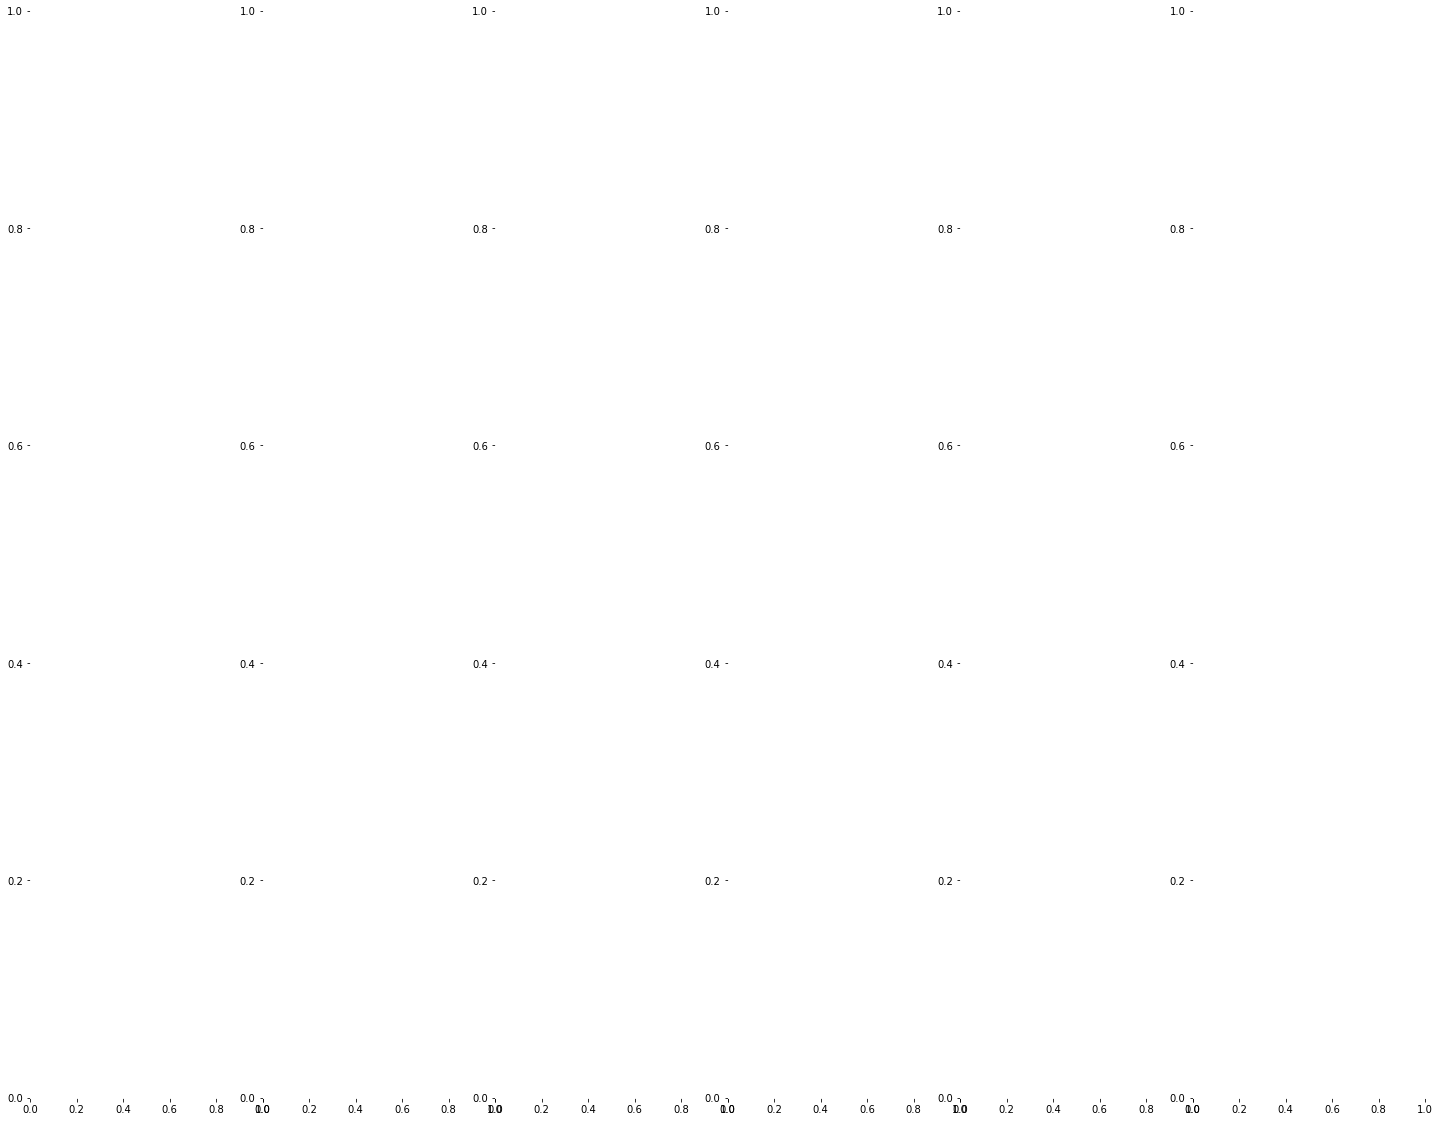

In [15]:

dirname = sim_save_dir
list_dir = os.listdir(sim_save_dir)
import matplotlib
import matplotlib.gridspec as gridspec
from polarity.toolbox import open_sheet,depth_calculation, all_depth_calculation


matplotlib.rc('axes', edgecolor='white')

result_dataframe = pd.DataFrame(index = list_dir, columns = ('time', 'depth', 'Fab/Fc'))




fig = plt.figure(figsize=(25, 20))
grid = gridspec.GridSpec(1, 6, wspace=0.0, hspace=0.0)


axes_0_0 = fig.add_subplot(grid[0, 0])
axes_0_1 = fig.add_subplot(grid[0, 1])
axes_0_2 = fig.add_subplot(grid[0, 2])
axes_0_3 = fig.add_subplot(grid[0, 3])
axes_0_4 = fig.add_subplot(grid[0, 4])
axes_0_5 = fig.add_subplot(grid[0, 5])




panel_sagittal_view(dirname/'100.0_barrierray0/', ax=axes_0_0)
panel_sagittal_view(dirname/'95.0_barrierray0/', ax=axes_0_1)
panel_sagittal_view(dirname/'90.0_barrierray0/', ax=axes_0_2)
panel_sagittal_view(dirname/'85.0_barrierray0/', ax=axes_0_3)
panel_sagittal_view(dirname/'80.0_barrierray0/', ax=axes_0_4)
panel_sagittal_view(dirname/'75.0_barrierray0/', ax=axes_0_5)




#result_dataframe.to_csv('result_principal_result.csv')
plt.savefig('external_barrier_effect.eps', dpi = 300, transparent=True)
plt.savefig('external_barrier_effect.png', dpi = 300, transparent=True)